In [87]:
import tensorflow as tf
import numpy as np

import pandas as pd
import cv2
import os
import math
import scipy as sp
import PIL

# Tensorflow
from tensorflow.keras import models, layers, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, ZeroPadding2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2, imagenet_utils
from sklearn.metrics import confusion_matrix

import scikitplot as skplt
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [2]:
# batch_size: 한번에 forward & Backword 하는 샘플의 수
batch_size = 32

# Training 수
epochs = 100

# Weight 조절 parameter
LearningRate = 1e-3 # 0.001
Decay = 1e-6

img_width = 225
img_height = 225

In [3]:
CurrentDirectory = '../dataset/'

train_directory = CurrentDirectory + 'train/'
test_directory  = CurrentDirectory + 'test/'
model_directory = CurrentDirectory + '../MODEL/'
tensorboard_directory = CurrentDirectory + '../Tensorboard'

In [4]:
# 모델 Return
MobileNetV2Model= tf.keras.applications.MobileNetV2(
    input_shape=(img_width,img_height,3),
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None)
x = GlobalAveragePooling2D()(MobileNetV2Model.output)
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
predictions = Dense(3, activation='sigmoid')(x)
# Input ~ Output 연결해주기
DeepLearning = Model(inputs=MobileNetV2Model.input, outputs=predictions)

# learning parameter를 더하여 최종 model compile
DeepLearning.compile(optimizer=
         SGD(lr=LearningRate, decay=Decay, momentum=0.9, nesterov=True), 
         loss='categorical_crossentropy',
         metrics=['acc']
) # 나이를, MSE

9406464/9406464 [==============================] - 0s 0us/step


c:\Users\gmlkd\miniforge3\envs\tensor2.9\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [6]:
# Online-augmentation 적용 Generator
# 1. 이미지를 전부다 불러서 램 (메모리)에 올릴 수 없기 때문
# 2. 이미지는 Augmentation을 해주는게 좋아서

DATAGEN_TRAIN = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last",
    validation_split=0.10) # Train / Validation

# Online-augmentation 비적용 Generator (Test용)
DATAGEN_TEST = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last")

In [7]:
# Generator의 instance 생성 (Train)
TRAIN_GENERATOR = DATAGEN_TRAIN.flow_from_directory(
    train_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode= "categorical",
    subset = "training")

VALID_GENERATOR = DATAGEN_TRAIN.flow_from_directory(
    train_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode="categorical",
    subset = "validation")

# Generator의 instance 생성 (Test)
TEST_GENERATOR = DATAGEN_TEST.flow_from_directory(
    test_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False,
    class_mode='categorical')

Found 734 images belonging to 3 classes.
Found 80 images belonging to 3 classes.
Found 91 images belonging to 3 classes.


In [58]:
TEST_GENERATOR.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2])

In [8]:
# Call-back 함수

# CheckPoint: Epoch 마다 validation 성능을 검증하여, best performance 일 경우 저장
CP = ModelCheckpoint(filepath=model_directory+'MobileNetV2-{epoch:03d}-{val_loss:.4f}-{val_acc:.4f}.hdf5',
            monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# 학습과정 진행사항 확인
TB = TensorBoard(log_dir=tensorboard_directory, write_graph=True, write_images=True)

# Learning Rate 줄여나가기
LR = ReduceLROnPlateau(monitor='val_loss',factor=0.8,patience=3, verbose=1, min_lr=1e-8)

CALLBACK = [CP, TB, LR]

In [9]:
with tf.device("/device:GPU:0"):
        history = DeepLearning.fit_generator(
                TRAIN_GENERATOR,
                # steps_per_epoch=TRAIN_GENERATOR.n / batch_size,
                epochs=epochs,
                callbacks=CALLBACK,
                shuffle=True, # Training에 패턴이 존재하면 overfit이 잘 되기 때문에, Shuffle 사용해야함. 단 test에는 절대 X
                validation_data=VALID_GENERATOR)

C:\Users\gmlkd\AppData\Local\Temp\ipykernel_2596\3034265299.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  DeepLearning.fit_generator(
c:\Users\gmlkd\miniforge3\envs\tensor2.9\lib\site-packages\keras\preprocessing\image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\Users\gmlkd\miniforge3\envs\tensor2.9\lib\site-packages\keras\preprocessing\image.py:1671: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
23/23 [==============================] - ETA: 0s - loss: 1.0732 - acc: 0.4796
Epoch 1: val_acc improved from -inf to 0.55000, saving model to ../dataset/../MODEL\MobileNetV2-001-0.9755-0.5500.hdf5
23/23 [==============================] - 16s 449ms/step - loss: 1.0732 - acc: 0.4796 - val_loss: 0.9755 - val_acc: 0.5500 - lr: 0.0010
Epoch 2/100
23/23 [==============================] - ETA: 0s - loss: 0.6528 - acc: 0.7657
Epoch 2: val_acc did not improve from 0.55000
23/23 [==============================] - 9s 388ms/step - loss: 0.6528 - acc: 0.7657 - val_loss: 1.2258 - val_acc: 0.4875 - lr: 0.0010
Epoch 3/100
23/23 [==============================] - ETA: 0s - loss: 0.4809 - acc: 0.8229
Epoch 3: val_acc did not improve from 0.55000
23/23 [==============================] - 9s 398ms/step - loss: 0.4809 - acc: 0.8229 - val_loss: 1.0802 - val_acc: 0.5375 - lr: 0.0010
Epoch 4/100
23/23 [==============================] - ETA: 0s - loss: 0.3912 - acc: 0.8597
Epoch 4: val_acc did not i

In [10]:
DeepLearning.load_weights(model_directory+'MobileNetV2-089-0.3565-0.9250.hdf5')

In [11]:
prediction = DeepLearning.predict(TEST_GENERATOR, verbose=1)

c:\Users\gmlkd\miniforge3\envs\tensor2.9\lib\site-packages\keras\preprocessing\image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\Users\gmlkd\miniforge3\envs\tensor2.9\lib\site-packages\keras\preprocessing\image.py:1671: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


3/3 [==============================] - 1s 180ms/step


In [13]:
Result = pd.DataFrame(prediction)
Result

,0,1,2
0,0.891443,0.040257,0.607437
1,0.998034,0.061743,0.007353
2,0.970399,0.091075,0.215295
3,0.921385,0.041969,0.784807
4,0.988280,0.049735,0.155549
...,...,...,...
86,0.081579,0.141124,0.967623
87,0.129755,0.214087,0.954455
88,0.174862,0.133242,0.982040
89,0.107839,0.396587,0.878742


In [85]:
Result.iloc[60:]

,0,1,2
60,0.089724,0.006591,0.992500
61,0.093017,0.103669,0.959554
62,0.108823,0.043440,0.996305
63,0.292536,0.638150,0.916907
64,0.248560,0.268356,0.912346
65,0.087379,0.035617,0.992368
66,0.073909,0.009973,0.996205
67,0.448867,0.496245,0.365006
68,0.131332,0.053066,0.991671
69,0.417008,0.082446,0.856370


<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

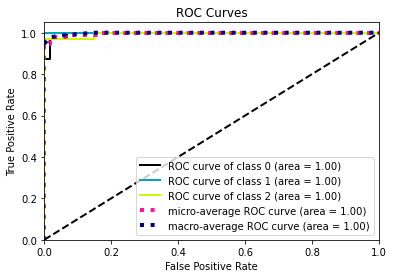

In [14]:
skplt.metrics.plot_roc(TEST_GENERATOR.classes.tolist(), Result)

In [2]:
def prepare_image(file):
    img_path = test_directory + 'muzzle/'
    img = image.load_img(img_path + file, target_size=(225, 225))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [3]:
preprocessed_image = prepare_image('PCM20181227000209990_P2.jpg')
predictions = DeepLearning.predict(preprocessed_image)
predictions

NameError: name 'test_directory' is not defined